In [21]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

In [22]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, we filter the data to select columns including winner_age, loser_age, surface, loser_rank, winner_rank, and minutes, and the "surface" column is use to create a new column called "surface_type" by using case_when function. Then the new "surface_type" column is select along the other selected columns. 
Afterthat, we filter out any rows that contain missing values for the selected columns by using the !is.na function.  

In [23]:
tennis_data <- tennis %>%
  select(winner_age, loser_age, surface,loser_rank, winner_rank, minutes, winner_id, loser_id) %>%
  mutate(surface_type = case_when(
    surface == "Hard" ~ "Hard",
    surface == "Clay" ~ "Clay",
    surface == "Grass" ~ "Grass",
    TRUE ~ NA_character_
  )) %>%
  mutate(surface_type = as_factor(surface_type)) %>%
  select(surface_type, winner_age, loser_age, loser_rank, winner_rank, minutes, winner_id, loser_id) %>%
  filter(!is.na(winner_age) & !is.na(loser_age) & !is.na(surface_type) & 
         !is.na(loser_rank) & !is.na(winner_rank) & !is.na(minutes))

head(tennis_data)

surface_type,winner_age,loser_age,loser_rank,winner_rank,minutes,winner_id,loser_id
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hard,29.00479,22.88569,16,9,124,105453,106421
Hard,22.88569,33.70568,239,16,82,106421,104542
Hard,29.00479,31.88227,40,9,66,105453,104871
Hard,33.70568,19.86858,31,239,106,104542,200282
Hard,22.88569,28.01095,18,16,129,106421,105683
Hard,31.88227,26.40383,185,40,127,104871,106034


Then, we first use the initial_split function to separate the data to training and test sets. We specify that prop = 0.75 so that 75% of our original data set ends up in the training set, and the split was stratified based on surface_type, to ensure that the training and testing subsets contain the right proportions of each category of observation. We can see from glimpse in the code that the training set contains 5040 observations, while the test set contains 1682 observations. This corresponds to a train / test split of 75% / 25%, as desired. 

In [24]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = surface_type)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 5,040
Columns: 8
$ surface_type <fct> Clay, Clay, Clay, Clay, Clay, Clay, Clay, Clay, Clay, Cla…
$ winner_age   <dbl> 25.47296, 28.72005, 25.47296, 25.47296, 28.33402, 33.0924…
$ loser_age    <dbl> 28.72005, 33.09240, 28.33402, 23.81656, 21.75222, 35.0417…
$ loser_rank   <dbl> 59, 92, 77, 280, 81, 43, 168, 71, 23, 74, 76, 149, 116, 4…
$ winner_rank  <dbl> 112, 59, 112, 112, 77, 92, 20, 59, 280, 77, 65, 92, 71, 1…
$ minutes      <dbl> 123, 112, 60, 108, 116, 82, 141, 125, 71, 165, 86, 83, 15…
$ winner_id    <dbl> 106228, 105550, 106228, 106228, 105643, 104655, 106043, 1…
$ loser_id     <dbl> 105550, 104655, 105643, 106398, 144719, 104291, 105561, 1…
Rows: 1,682
Columns: 8
$ surface_type <fct> Hard, Hard, Hard, Hard, Hard, Hard, Hard, Hard, Hard, Har…
$ winner_age   <dbl> 29.00479, 31.63039, 27.62765, 26.37098, 23.22245, 23.5455…
$ loser_age    <dbl> 22.88569, 26.94319, 23.26078, 21.17454, 31.73717, 29.4620…
$ loser_rank   <dbl> 16, 234, 75, 49, 50, 59, 100, 30, 132, 149, 120, 96, 

In [25]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(surface_type) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

tennis_proportions

surface_type,n,percent
<fct>,<int>,<dbl>
Hard,2900,57.53968
Clay,1537,30.49603
Grass,603,11.96429


In [26]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(surface_type ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = surface_type)

In [27]:
set.seed(999) 

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4642922,5,0.008662279,Preprocessor1_Model01
3,accuracy,multiclass,0.4906821,5,0.005737364,Preprocessor1_Model02
4,accuracy,multiclass,0.5009954,5,0.004379911,Preprocessor1_Model03
6,accuracy,multiclass,0.5150792,5,0.002864638,Preprocessor1_Model04
7,accuracy,multiclass,0.5238125,5,0.003809030,Preprocessor1_Model05
8,accuracy,multiclass,0.5230184,5,0.003736066,Preprocessor1_Model06
10,accuracy,multiclass,0.5335306,5,0.003162135,Preprocessor1_Model07
12,accuracy,multiclass,0.5410724,5,0.005969938,Preprocessor1_Model08
13,accuracy,multiclass,0.5424568,5,0.005627781,Preprocessor1_Model09


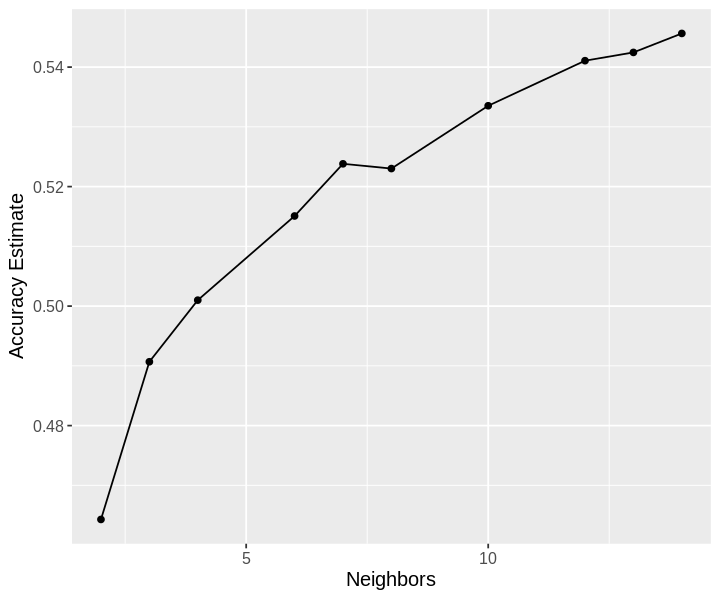

In [28]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

In [29]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(18,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4470238
Best kernel: rectangular
Best k: 18

In [30]:
set.seed(9999) 

# your code here
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
tennis_metrics <- tennis_predictions |>
         metrics(truth = surface_type, estimate = .pred_class) |>
  filter(.metric == "accuracy")
tennis_mat <- tennis_predictions |>
         conf_mat(truth = surface_type, estimate = .pred_class)
head(tennis_predictions)
tennis_metrics
tennis_mat

.pred_class,surface_type,winner_age,loser_age,loser_rank,winner_rank,minutes,winner_id,loser_id
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hard,Hard,29.00479,22.88569,16,9,124,105453,106421
Hard,Hard,31.63039,26.94319,234,240,88,104918,105902
Clay,Hard,27.62765,23.26078,75,19,79,105777,106415
Hard,Hard,26.37098,21.17454,49,63,144,106045,126203
Hard,Hard,23.22245,31.73717,50,43,158,111797,104898
Hard,Hard,23.54552,29.46201,59,74,55,109739,105376


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5564804


          Truth
Prediction Hard Clay Grass
     Hard   843  416   179
     Clay   121   93    23
     Grass    3    4     0

The mean and standard deviation of winner_age, loser_age, winner_rank, loser_rank, and minutes were calculated for each surface_type using the summarize function. 

In [31]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(surface_type) %>%
  summarize(
    avg_winner_age = mean(winner_age),
    avg_loser_age = mean(loser_age),
    avg_winner_rank = mean(winner_rank),
    avg_loser_rank = mean(loser_rank),
    avg_minutes = mean(minutes)
  )

tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(surface_type) %>%
  summarize(
    sd_winner_age = sd(winner_age),
    sd_loser_age = sd(loser_age),
    sd_winner_rank = sd(winner_rank),
    sd_loser_rank = sd(loser_rank),
    sd_minutes = sd(minutes)
  )

tennis_summary_sd

surface_type,avg_winner_age,avg_loser_age,avg_winner_rank,avg_loser_rank,avg_minutes
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hard,27.57468,27.46683,54.82897,79.10690,108.1376
Clay,27.43618,27.57943,62.79636,88.98829,113.6480
Grass,28.78132,27.70425,54.76783,88.82587,114.8292


surface_type,sd_winner_age,sd_loser_age,sd_winner_rank,sd_loser_rank,sd_minutes
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hard,4.596324,4.457530,62.62322,89.35356,39.98686
Clay,4.275295,4.454291,65.20157,103.69726,40.72101
Grass,4.571884,4.401125,60.71541,94.76231,45.55471


A scatter plot was created using the ggplot function. The plot shows the corralation between loser_age and loser_rank on the x and y axes, respectively, and between winner_age and winner_rank using different colors for each group. 

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



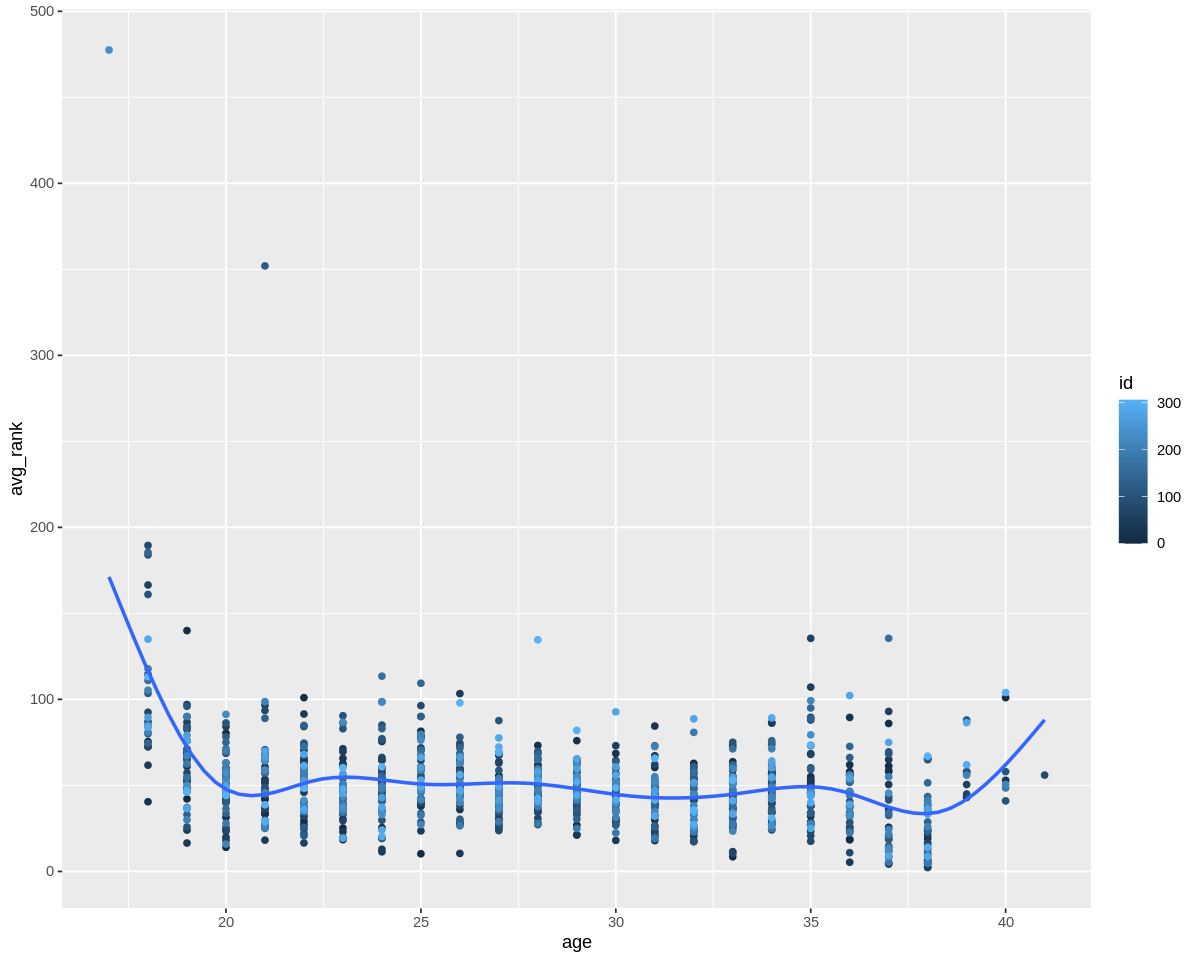

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



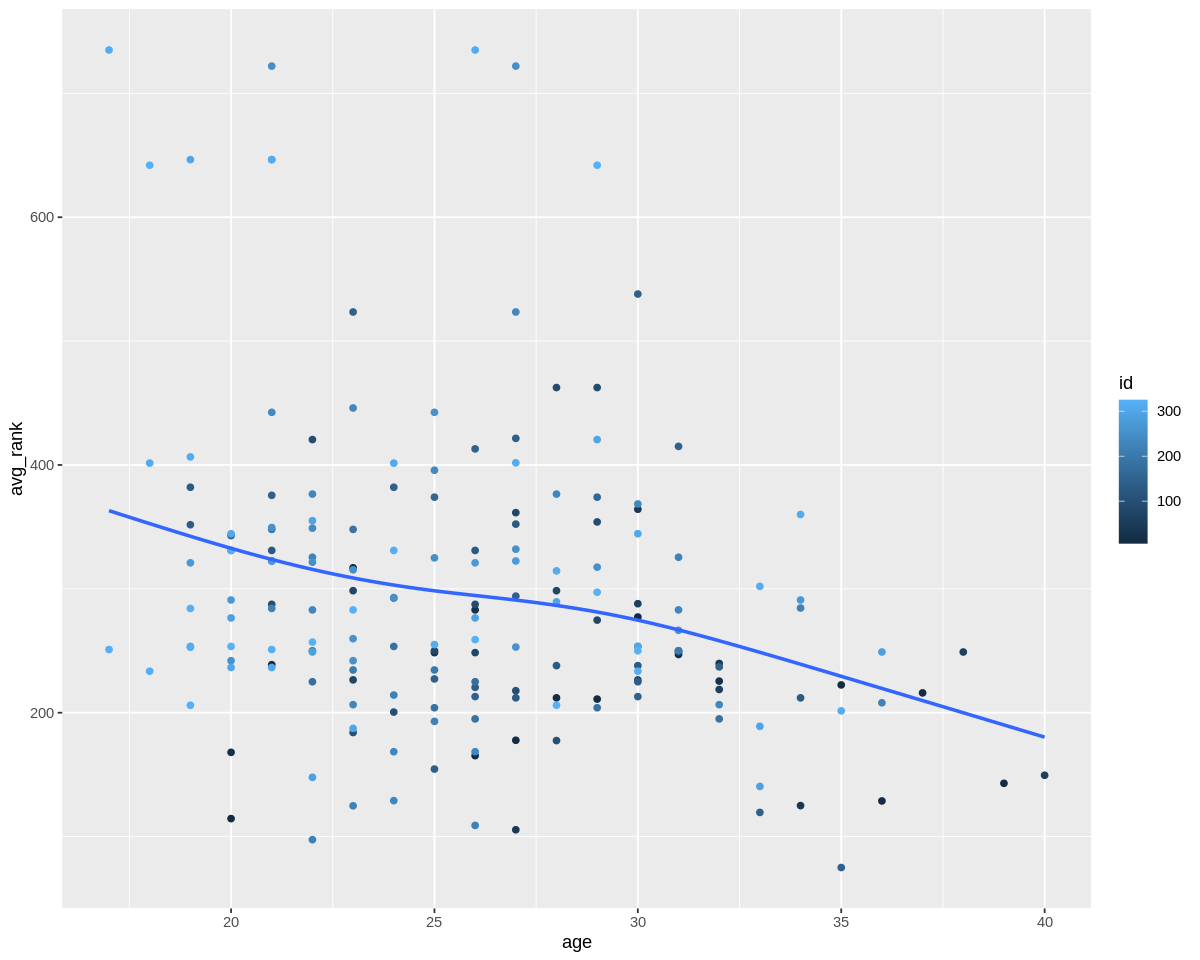

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



In [ ]:
set.seed(999)
options(repr.plot.width = 10, repr.plot.height = 8)

#big list of ranks, ages, and player ids, regardless of winner or loser
rank_age_avg <- tennis_data |>
    select(-surface_type, -minutes) |>
    pivot_longer(cols = c("winner_age", "loser_age"), names_to = "age_type", values_to = "age") |>
    pivot_longer(cols = c("winner_rank", "loser_rank"), names_to = "rank_type", values_to = "rank") |>
    pivot_longer(cols = c("winner_id", "loser_id"), names_to = "id_type", values_to = "id") |>
    select(id, rank, age) |>
    drop_na()

#rank average for player at age
rank_avgforageforplayer <- rank_age_avg |>
    mutate(age = round(age, 0.1)) |>
    group_by(id, age) |>
    summarize(avg_rank = mean(rank, na.rm = TRUE)) |>
    group_by(id) |>
    mutate(new_id = cur_group_id() - 1) |>
    ungroup() |>
    select(-id) |>
    mutate(id = new_id) |>
    select(-new_id)

top_50_ids <- rank_avgforageforplayer %>% 
  group_by(id) %>% 
  summarise(rank = mean(avg_rank)) %>% 
  ungroup() %>% 
  arrange(rank) %>% 
  slice(1:50) %>% 
  pull(id)

top_50_df <- rank_avgforageforplayer %>% 
  filter(id %in% top_50_ids)

bot_50_ids <- rank_avgforageforplayer %>% 
  group_by(id) %>% 
  summarise(rank = mean(avg_rank)) %>% 
  ungroup() %>% 
  arrange(desc(rank)) %>% 
  slice(1:50) %>% 
  pull(id)

bot_50_df <- rank_avgforageforplayer %>% 
  filter(id %in% bot_50_ids)

most_fluc_ids <- group_by(rank_avgforageforplayer, id) %>% 
  summarise(rank_fluctuation = max(avg_rank) - min(avg_rank)) %>% 
  arrange(desc(rank_fluctuation)) %>% 
  head(50) %>% 
  pull(id)

most_fluc_df <- rank_avgforageforplayer %>% 
  filter(id %in% most_fluc_ids)

ggplot(top_50_df, aes(x = age, y = avg_rank, color = id)) +
    geom_point() +
    geom_smooth(method = "gam", se = FALSE)

ggplot(bot_50_df, aes(x = age, y = avg_rank, color = id)) +
    geom_point() +
    geom_smooth(method = "gam", se = FALSE)

ggplot(most_fluc_df, aes(x = age, y = avg_rank, color = id)) +
    geom_point() +
    geom_smooth(method = "gam", se = FALSE)

#rank average for ages
rank_avgforage <- rank_age_avg |>
    select(-id) |>
    mutate(age = round(age, 1)) |>
    group_by(age) |>
    summarize(avg_rank = mean(rank, na.rm = TRUE))

ggplot(rank_avgforageforplayer, aes(x = age, y = avg_rank, color = id)) +
    geom_point() +
    geom_smooth(method = "gam", se = FALSE)

ggplot(rank_avgforage, aes(x = age, y = avg_rank)) +
    geom_point() +
    geom_smooth(method = "gam", se = FALSE)

ggplot(tennis_train) +
  geom_point(aes(x = loser_age, y = loser_rank, color = "Loser")) +
  geom_point(aes(x = winner_age, y = winner_rank, color = "Winner")) +
  scale_color_manual(values = c("Loser" = "blue", "Winner" = "red")) +
  xlab("Age") +
  ylab("Rank") +
  theme_bw() +
  theme( text = element_text(size = 20))


In [ ]:
set.seed(999)
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(tennis_train) +
  geom_point(aes(x = loser_age, y = loser_rank, color = "Loser")) +
  geom_point(aes(x = winner_age, y = winner_rank, color = "Winner")) +
  scale_color_manual(values = c("Loser" = "blue", "Winner" = "red")) +
  xlab("Age") +
  ylab("Rank") +
  theme_bw() +
  theme( text = element_text(size = 20))


Line plots were created for each surface_type using ggplot function. Each plot shows the distribution of minutes by winner_age for each surface type. 

In [ ]:
set.seed(999)
# hard surface
hard_plot <- ggplot(data = filter(tennis_train, surface_type == "Hard"),
                    aes(x = winner_age, y = minutes)) +
  geom_line() +
  labs(title = "Hard Surface",
       x = "Winner Age",
       y = "Minutes")

# clay surface
clay_plot <- ggplot(data = filter(tennis_train, surface_type == "Clay"),
                    aes(x = winner_age, y = minutes)) +
  geom_line() +
  labs(title = "Clay Surface",
       x = "Winner Age",
       y = "Minutes")

# grass surface
grass_plot <- ggplot(data = filter(tennis_train, surface_type == "Grass"),
                     aes(x = winner_age, y = minutes)) +
  geom_line() +
  labs(title = "Grass Surface",
       x = "Winner Age",
       y = "Minutes")

hard_plot
clay_plot
grass_plot

A box plot was created using ggplot function to compare the distribution of minutes across surface_type. The plot shows the median, quartiles, and outliers of the minutes distribution for each surface_type.

In [ ]:
set.seed(999)
minutes_plot <- ggplot(tennis_train, aes(x = surface_type, y = minutes)) +
  geom_boxplot() +
  xlab("Surface Type") +
  ylab("Minutes") +
  theme_bw() +
  theme(text = element_text(size = 20))

minutes_plot